# Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Data

In [8]:
data = pd.read_csv("./data/wina.pl_clean.csv")
data.head(1)

,name,link,price (PLN),country,region,appellation,vineyard,vintage,volume (liters),alcohol (%),serving temperature (C),color,kind,taste,style,medals,wegan,natural,punctation,grapes
0,Szampan Moet & Chandon Brut Imperial Magnum w ...,https://www.wina.pl/szampany/3056-15-l-szampan...,666.0,Francja,Szampania,Champagne AOC,Moet & Chandon,NaN,1.5,NaN,9,NaN,szampan,wytrawne,średnie,NaN,False,False,NaN,Chardonnay


# Is *Amerena* exist in dataset?

In [33]:
data[data["name"].str.lower().str.contains("amarena")]

,name,link,price (PLN),country,region,appellation,vineyard,vintage,volume (liters),alcohol (%),serving temperature (C),color,kind,taste,style,medals,wegan,natural,punctation,grapes


No, there are no *Amarena* wine in store, so it's a good sign.

---

# In which country the median price of wine is the highest?

In [58]:
price_by_country = data[["price (PLN)", "country"]]\
    .groupby(["country"])\
    .agg(["median", "count"])\
    .sort_values(("price (PLN)", "median"), ascending=False)
price_by_country.head()

price (PLN)      
              median count
country                   
Irlandia       519.0     1
Liban          234.5     8
Francja        188.0   500
Szkocja        178.5     2
Słowacja       171.0     2

The highest median price is in **Ireland**, but it is an outlier. Let's try to calculate pvalue.

In [61]:
from scipy import stats

alpha = 0.05
valid_countries = []

for country in data["country"].unique():
    result = stats.ttest_ind(
        data[data["country"] != country].loc[:, "price (PLN)"].dropna(),
        data[data["country"] == country].loc[:, "price (PLN)"].dropna()
    )
    if result.pvalue < alpha:
        valid_countries.append(country)

price_by_country.loc[valid_countries]

price (PLN)      
               median count
country                    
Francja         188.0   500
Hiszpania        79.0   352
Niemcy           79.0    73
POLSKA           93.5    84

The highest median price actually is in **France**.

---

# What is correlation between alcohol content and price?

In [24]:
data[["price (PLN)", "alcohol (%)"]].dropna().corr()

,price (PLN),alcohol (%)
price (PLN),1.000000,0.081327
alcohol (%),0.081327,1.000000


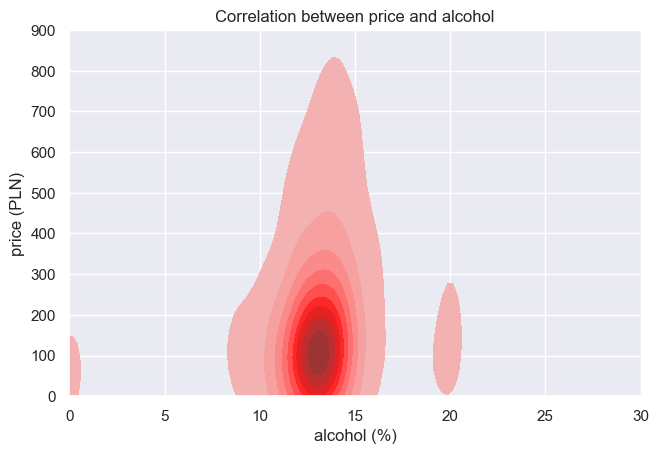

In [ ]:
sns.displot(
    data=data[["price (PLN)", "alcohol (%)"]].dropna(),
    x="alcohol (%)", y="price (PLN)",
    kind="kde", fill=True, color='red',
    height=4.5, aspect=1.5
)
plt.xlim(0, 30)
plt.ylim(0, 900)
plt.title("Correlation between price and alcohol content")
plt.show()

Correlation is positive and is equal to 8%.

---

# What is correlation between vintage and price?

In [30]:
data[["price (PLN)", "vintage"]].dropna().corr()

,price (PLN),vintage
price (PLN),1.000000,-0.351841
vintage,-0.351841,1.000000


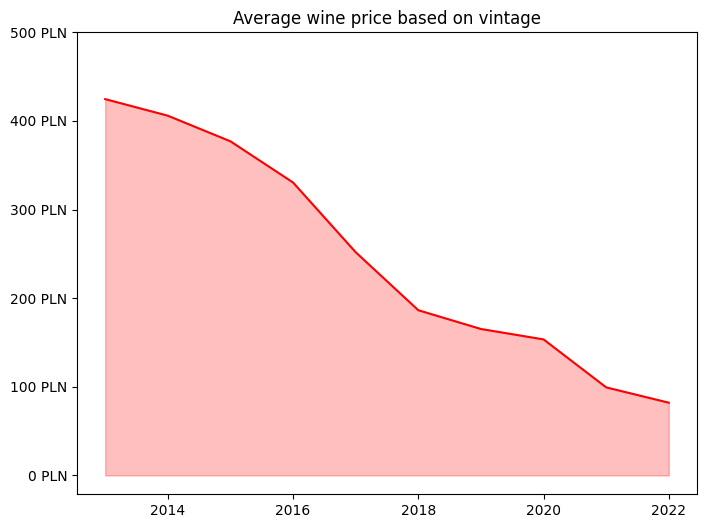

In [6]:
valid_years = data["vintage"].value_counts()
valid_years = valid_years[valid_years > 10].index

vintage_price = data[["price (PLN)", "vintage"]].dropna()
vintage_price = vintage_price[vintage_price["vintage"].isin(valid_years)]
vintage_price = vintage_price.groupby("vintage").mean()

plt.figure(figsize=(8, 6))
plt.plot(
    vintage_price.index, vintage_price["price (PLN)"],
    color="red"
)
plt.fill_between(
    vintage_price.index, np.zeros(len(vintage_price.index)), vintage_price["price (PLN)"],
    color="red", alpha=0.25
)
plt.title("Average wine price based on vintage")
plt.yticks(np.arange(0, 501, 100), [f"{price} PLN" for price in np.arange(0, 501, 100)])
plt.show()

---

# Regional Specialties. Which regions are associated with specific kinds of wine?

In [11]:
valid_countries = data["country"].value_counts()
valid_countries = valid_countries[valid_countries > 25]
valid_countries = valid_countries.index

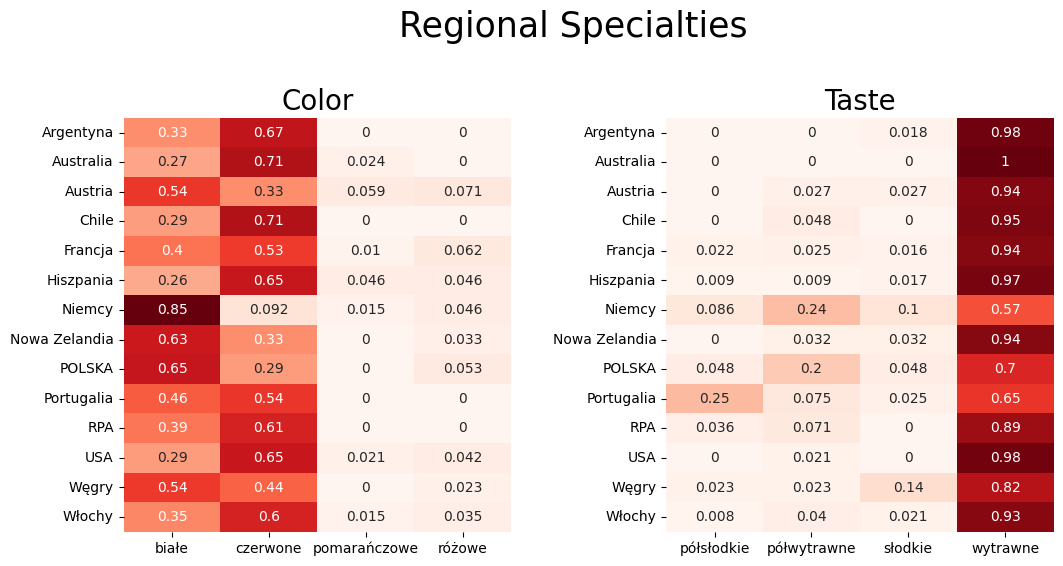

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Color
color = data[data["country"].isin(valid_countries)]\
    .pivot_table(index="country", columns="color", aggfunc="size", fill_value=0)
color = color.transform(lambda column: round(column / color.sum(axis=1), 3))
sns.heatmap(color, annot=True, cmap="Reds", ax=ax[0], cbar=False)
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_title("Color", fontsize=20)

# Taste
taste = data[data["country"].isin(valid_countries)]\
    .pivot_table(index="country", columns="taste", aggfunc="size", fill_value=0)
taste = taste.transform(lambda column: round(column / taste.sum(axis=1), 3))
sns.heatmap(taste, annot=True, cmap="Reds", ax=ax[1], cbar=False)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("Taste", fontsize=20)

plt.subplots_adjust(wspace=0.4, top=0.8)
plt.suptitle("Regional Specialties", fontsize=25)
plt.show()